# Final Project - Analysis of Census Income Data

## Dane Jordan

__Note: The relative links in the "Contents" section below do not work in the GitHub interface when viewing the ipynb. Should you wish to use the links you will need to download the ipynb.__

## Contents

- [Introduction](#Introduction)
- [Background/Related Work](#Background/Related-Work)
  - [Research Questions](#Research-Questions)
- [Methods](#Methods)
  - [Getting the census income data](#Getting-the-census-income-data)
  - [Exploratory data analysis - EDA](#Exploratory-data-analysis---EDA)
  - [Data cleaning](#Data-cleaning)
  - [Deal with missing values and encode categorical features](#Deal-with-missing-values-and-encode-categorical-features)
  - [Modeling](#Modeling)
    - [Split DataFrame into training and testing](#Split-DataFrame-into-training-and-testing)
    - [Split into features/response, training/validation, and standardize/scale data](#Split-into-features/response,-training/validation,-and-standardize/scale-data)
- [Findings](#Findings)
  - [Fit logistic regression model with cross-validation and calculate accuracy](#Fit-logistic-regression-model-with-cross-validation-and-calculate-accuracy)
  - [Visualize the coefficients](#Visualize-the-coefficients)
  - [Visualize Pearson correlation confusion matrix among features](#Visualize-Pearson-correlation-confusion-matrix-among-features)
- [Discussion/Implications](#Discussion/Implications)
  - [Limitations](#Limitations)
  - [Future Research](#Future-Research)
- [Conclusion](#Conclusion)
- [References](#References)

## Introduction
[[back to Contents](#Contents)]

The data is provided by the US Census Bureau and has been archived in the University of California, Irvine (UCI) repository. It was obtained from [Kaggle](https://www.kaggle.com) on 11/9/2017. While the data is old, it is still important to see how certain features that contribute to income have changed over the years. This way we can determine whether there has been progress made in bridging the income gap based on these features. We may not necessarily be able to identify the problems causing these gaps in income, but this dataset will help detect where the gaps are so further investigation can be made into these areas. While we do not currently have a recent dataset for relating income to social factors, we believe that the analysis and results from the 1994 dataset could be replicated with a more recent dataset, to provide insight into how certain factors contributing to income have changed over time.

This analysis is performed with the intent of delivering a simple machine learning model that can be used to predict a binary income classification (greater than \$50,000, or less than or equal to $50,000) based on certain factors. We also intend to perform a high-level analysis on all features and the response variable, to find any significant correlations between them. This will help us determine whether income gaps exist based on these features.

The data is provided in two `.csv` files in the following format:

Column | Type | Description/Categories
--- | --- | ---
age | int | self-describing
type_employer | str | the type of the employer the individual has (i.e. government, military, private, etc.).
fnlwgt | int | the final sampling weight (i.e. the number of people the census believes that observation represents)
education | str | the highest education attained
education_num | int | a numerical representation of the highest education attained
marital | str | marital status (i.e. married, single, divorced, etc.)
occupation | str | generic field of work
relationship | str | contains family relationship values like husband and father
race | str | self-describing
sex | boolean | sex at birth
capital_gain | int | income received other than salary
capital_loss | int | income lost other than salary
hr_per_week | int | number of hours worked per week
country | str | country of origin of the individual
income | boolean | less than \$50K, or greater than or equal to $50K

We often hear about "gaps" in income based on different factors. Some of these income gaps exist for reasons that are unknown, and many exist for reasons that are known but not enough has been done to address them. This analysis serves to objectively identify whether or not income gaps exist based on the features above. It does not necessarily identify the root cause or problem, but rather identifies where further research should be done. It narrows the scope of future research that may identiy the issues contributing to income gaps.

If income gaps exists, these could be deemed discriminatory and unfair to those that are being discriminated against. Everyone deserves equal opportunity, however, that is not necessarily the case. Identifying that there is a problem is the first step towards correcting it.

## Background/Related Work
[[back to Contents](#Contents)]

There has been a significant amount of research performed regarding income gaps. Much of the research done has been about the discrepancies between the social strata. Those in the top 1% of earners received approximately 10% of the income generated in the US between 1950 and 1980. As of 2013 the top 1% received approximately 20% of the income, showing that the gap is widening. Various rationales have been posed to potentially explain this increasing stratification including skill-biased technological changes, immigration of less-educated workers, a shift between the corporate and financial sectors, and policy changes, politics, and race.

Even back in the 1990s studies were being done with respect to the "gender pay gap" focusing on its slowing convergence between female and male wages <sup>[8]</sup>. __We would like to note that within this article gender is used in place of sex which is incorrect. The two are different and not to be confused with one another. Sex is binary (except in some extreme cases) and determined by our sexual organs at birth, whereas gender is how we choose or choose not to identify.__ The researchers found that "labor force selectivity," and "labor market discrimination," contributed the most to the slowing convergence in the income gap.

With this prior work in mind, we form some research questions under the assumption that income gaps already exist. We choose to look at the extent to which these income gaps exist by asking the following research questions.

### Research Questions

1. Given a set of features, can we predict whether the income of a person will be greater than or less than $50,000?

2. Which feature is the most important in determining income classification?

3. Ignoring income, what factors appear to be highly correlated with each other?

## Methods
[[back to Contents](#Contents)]

The analysis for this project will be done using Python 3 in the Jupyter Notebook environment. Packages used include `matplotlib`, `numpy`, `pandas`, `seaborn`, and `scikit-learn`. The data and project are available here on GitHub.

The data will first need to be cleaned with missing values imputed, deleted, or replaced with null values. The columns currently do not have headers and the headers from the [introduction](#Introduction) above had to be obtained separately from the US Census Bureau. The two datasets will also be combined for the analysis portion of this study and split later for the machine learning model.

For the machine learning process, we plan to use a simple Logistic Regression classification model as this is a binary classification problem given the `income` feature. The entire process from raw data acquisition to modeling is reproducible with the code in this `ipynb`. Should a newer dataset be obtained, it should be possible to format it in such a way that the code below could be run on it and achieve replicable results.

Import necessary libraries that will be used

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Turn off unnecessary warnings. When reassigning columns while changing categorical variables into numerical equivalents or boolean alternatives, pandas throws a warning for a `SettingWithCopyWarning`. This is unnecessary for our purposes and as such it has been turned off to not add confusion during this analysis.

In [2]:
# turn off warning for chained assignment (unnecessary for operation)
pd.options.mode.chained_assignment = None

Define functions that will be used throughout the analysis. To save ourselves from repetitive code use, we have implemented some functions. They are as follows:
- `binarize_cat_vars` - encodes the categorical features as new features in a boolean format (extends the feature space significantly)
- `corr_heatmap` - visualize Pearson correlation heatmap for a DataFrame
- `data_prep` - separates the features and response, splits the data into a training and testing set, and standardizes/scales the feature data appropriately
- `encode_cat_vars` - arbitrarily encodes the categorical features as numeric
- `model_logistic` - trains a LogisticRegressionCV() model and returns accuracy scores against a validation set and a test set
- `visualize_coefs` - plots a bar graph of the fitted model coefficients (sorted)

In [3]:
def binarize_cat_vars(df):
    
    '''
    encodes the categorical features as new features in a boolean format (extends the feature space significantly)
    :param df: DataFrame to be encoded
    '''
    
    # assing the label binarizer and label encoder
    lb = LabelBinarizer()
    le = LabelEncoder()
    
    # create list of labels
    label_list = ['type_employer',
                  'marital',
                  'occupation',
                  'relationship',
                  'race',
                  'country']
    
    # create a second list for boolean labels
    binary_label_list = ['sex',
                         'income']
    
    # change the categorical variables to features and associated binary indicator
    for i in df[label_list]:
        k = 0
        for j in sorted(df[i].unique()):
            df[str(i + '_' + j)] = lb.fit_transform(df[i])[:, k]
            k += 1
    
    # change the categorical variables that are already binary to numerical
    for i in binary_label_list:
        df[i] = le.fit_transform(df[i])
    
    # drop columns that have been binarized
    df = df.drop(label_list, axis=1)
    
    # return new df with categorical variables encoded as features
    return df


def convert_table_markdown(df, filename):
    
    '''
    This function takes in a 2-column dataframe and converts it into a markdown table
    :param df: pandas dataframe
    :param filename: str saved file name
    '''
    
    # header row
    df_table = df.columns[0] + ' | ' + df.columns[1] + '\n---' + ' | ' + '---'
    
    # loop through data rows and print
    for i in range(len(df)):
        df_table += '\n' + df[df.columns[0]][i].strip() + ' | ' + '%d' % df[df.columns[1]][i]
    
    # save file to disk
    df_markdown = open('../analysis/' + filename + '.txt', 'w')
    df_markdown.write(df_table)
    df_markdown.close()


def corr_heatmap(df, title_prefix='', figsize=(12, 12), annot=True, cbar=False, threshold=0, label_size=25, tick_size=20):
    
    '''
    visualize pearson correlation heatmap for a DataFrame
    :param df: DataFrame
    :param annot: boolean
    '''
    
    # round values to 2 decimals for cleaned looking annotations
    df = np.round(df.corr(), decimals=2) + 0
    
    # define figure
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df[(df >= threshold) | (df <= -threshold)], center=0, annot=annot, fmt='.2g', annot_kws={'size': 16}, square=True, cbar=cbar)
    sns.plt.title(str(title_prefix + 'Pearson Correlations'), fontsize=30)
    sns.plt.xlabel('Features', fontsize=label_size)
    sns.plt.xticks(fontsize=tick_size, rotation='vertical')
    sns.plt.ylabel('Features', fontsize=label_size)
    sns.plt.yticks(fontsize=tick_size, rotation='horizontal')
    plt.tight_layout()


def data_prep(df, train_size=0.67):
    
    '''
    separates the features and response, splits the data into a training and testing set,
    and standardizes/scales the feature data appropriately
    :param df: DataFrame containing feature/response data to be prepared
    :param train_size: percentage of data split into the training set
    '''

    # separate the features from the response
    df_features = df.drop(['income'], axis=1)
    df_response = df['income']

    # split the data into a training and testing set
    x_train, x_test, y_train, y_test = train_test_split(df_features,
                                                        df_response,
                                                        train_size=train_size,
                                                        random_state=6,
                                                        stratify=df_response)

    # assign the standard scaler
    scaler = StandardScaler()

    # standardize and scale the data (not including the response variable, income)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # return training and testing sets with features and response separated
    return x_train, x_test, y_train, y_test


def encode_cat_vars(df):

    '''
    arbitrarily encodes the categorical features as numeric
    :param df: DataFrame to be encoded
    '''
    
    # assign the label encoder
    le = LabelEncoder()
    
    # create list of labels
    label_list = ['type_employer',
                  'marital',
                  'occupation',
                  'relationship',
                  'race',
                  'sex',
                  'country',
                  'income']

    # change the categorical variables to an associated numerical label for ML
    for i in label_list:
        try:
            df[i] = le.fit_transform(df[i])
        except KeyError:
            pass

    # return new df with categorical variables encoded
    return df


def get_counts(feature):
    
    '''
    gets counts of the categories contained within a feature
    :param feature: the selected feature to get counts for
    '''
    
    return pd.DataFrame(df.groupby([feature])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)


def model_logistic(x_train, x_valid, x_test, y_train, y_valid, y_test):
    
    '''
    trains a LogisticRegressionCV() model and returns accuracy scores against a validation and test set
    :param x_train: DataFrame
    :param x_valid: DataFrame
    :param x_test: DataFrame
    :param y_train: DataFrame
    :param y_valid: DataFrame
    :param y_test: DataFrame
    '''
    
    # fit logisitc regression model
    clf_logCV = LogisticRegressionCV()
    clf_logCV.fit(x_train, y_train)
    
    # obtain predictions on validation set
    y_predict_valid = clf_logCV.predict(x_valid)
    print('Validation Accuracy: %.2f' % (metrics.accuracy_score(y_valid, y_predict_valid)*100) + '%')
    
    # obtain predictions on test set
    y_predict_test = clf_logCV.predict(x_test)
    print('Test Accuracy: %.2f' % (metrics.accuracy_score(y_test, y_predict_test)*100) + '%')
    
    # print confusion matrix
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y_test, y_predict_test))
    
    return clf_logCV


def visualize_coefs(model, df, title_prefix='', label_size=25, tick_size=25):
    
    '''
    plots a bar graph of the fitted model coefficients (sorted)
    :param model: fitted ML model
    :param df: DataFrame associated with model
    '''
    
    # define fig
    ax = pd.DataFrame({'coef': model.coef_[0], 'variable': df.columns[:-1]})
    ax.sort_values('coef').plot(x='variable', y='coef', kind='bar', figsize=(16, 12), fontsize=20, legend=False)
    plt.title(str(title_prefix + 'Logistic Regression Coefficients'), fontsize=30)
    plt.xlabel('Features', fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.ylabel('Coefficient Values', fontsize=label_size)
    plt.tight_layout()

### Getting the census income data

The dataset, "[US Adult Income](https://www.kaggle.com/johnolafenwa/us-census-data)," was obtained from [Kaggle](https://www.kaggle.com) on 11/09/2017. It was downloaded as a zipped folder and the `adult-training.csv` and `adult-test.csv` files were extracted.

- [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/)

A header is manually specified and the dataset is read into two pandas DataFrames below; one for the training set and one for the test set. The two are then combined. When reading in the data, all question marks are replaced with null values (missing data). We print the shape of the datasets to ensure that they are combined correctly and the dimensions are what we expect them to be.

In [4]:
# create header row as neither csv has a header
header = ['age',
          'type_employer',
          'fnlwgt',
          'education',
          'education_num',
          'marital',
          'occupation',
          'relationship',
          'race',
          'sex',
          'capital_gain',
          'capital_loss',
          'hr_per_week',
          'country',
          'income']

# read in the data from the two csv files
df_train = pd.read_csv('../data_raw/adult-training.csv', names=header, na_values=[' ?'])
df_test = pd.read_csv('../data_raw/adult-test.csv', names=header, skiprows=1, na_values=[' ?'])

# print the shape of the data
print('Shape of adult-training csv: ' + str(df_train.shape))
print('Shape of adult-test.csv: ' + str( df_test.shape))

# combine the two DataFrames into one dataset
df = df_train.append(df_test)

# print the shape of the full dataset
print('Shape of combined csv data: ' + str(df.shape))

Shape of adult-training csv: (32561, 15)
Shape of adult-test.csv: (16281, 15)
Shape of combined csv data: (48842, 15)


### Exploratory data analysis - EDA

At a high level we explore the data. We beging by looking for categorical variables, numerical variables, and determine how many possible values there are for each feature.

In [5]:
# create DataFrame for nice presentation
summary = pd.DataFrame(columns=['feature', 'unique_count', 'dtype'])

# loop through features and append summary statistics to the DataFrame
for i in df.columns:
    summary = summary.append(pd.DataFrame({'feature': [i],
                                           'unique_count': [str(len(df[i].unique()))],
                                           'dtype': [str(df[i].dtype)]}))

# print DataFrame
summary[['feature', 'dtype', 'unique_count']].reset_index(drop=True)

,feature,dtype,unique_count
0,age,int64,74
1,type_employer,object,9
2,fnlwgt,int64,28523
3,education,object,16
4,education_num,int64,16
5,marital,object,7
6,occupation,object,15
7,relationship,object,6
8,race,object,5
9,sex,object,2


It is interesting to see that the features `capital_gain` and `capital_loss` have such low unique counts. We would typically expect these to be quite high as they are not categorical in nature. The features `age`, `education_num` and `hr_per_week` are expected to be more categorical the lifespan of human rarely exceeds 100, the number of hours worked per week can only be a maximum of 168 (and even this number is impractical), and the `education_num` feature is simply a numerical representation of the `education` feature. The `fnlwgt` feature will not be used for the purposes of this analysis and will be removed during the [data cleaning](#Data-cleaning) process. Before moving forward we will look at the two education features to see if they confirm our assumption

In [6]:
# compare education_num and education features to see relationship
pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)

,education_num,education,count
0,1,Preschool,83
1,2,1st-4th,247
2,3,5th-6th,509
3,4,7th-8th,955
4,5,9th,756
5,6,10th,1389
6,7,11th,1812
7,8,12th,657
8,9,HS-grad,15784
9,10,Some-college,10878


Yes, it appears that our assumption is confirmed. Next we will look at some high-level summary statistics for the numerical values discussed above to see if we can gain any more insight into the data. Any 'zero' values are replaced by NaNs so that they are not counted. If any of the numerical features have a value of zero, this indicates that data does not exist for this individual. This does not necessarily mean data is 'missing,' but simply that it does not exist.

In [7]:
# high-level summary statistics for numerical values
df.replace(0, np.NaN).describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hr_per_week
count,48842.000000,4.884200e+04,48842.000000,4035.000000,2282.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,13061.665675,1872.825592,40.422382
std,13.710510,1.056040e+05,2.570973,22711.237412,364.048529,12.391444
min,17.000000,1.228500e+04,1.000000,114.000000,155.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,3411.000000,1672.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,7298.000000,1887.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,13550.000000,1977.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


--- | age | fnlwgt | education_num | capital_gain | capital_loss | hr_per_week
--- | --- | --- | --- | --- | --- | ---
count | 48842 | 48842 | 48842 | 4035 | 2282 | 48842
mean | 38.643585 | 189664.1 | 10.078089 | 13061.665675 | 1872.825592 | 40.422382
std | 13.710510 | 105604 | 2.570973 | 22711.237412 | 364.048529 | 12.391444
min | 17 | 12285 | 1 | 114 | 155 | 1
25% | 28 | 117550.5 | 9 | 3411 | 1672 | 40
50% | 37 | 178144.5 | 10 | 7298 | 1887 | 40
75% | 48 | 237642 | 12 | 13550 | 1977 | 45
max | 90 | 1490400 | 16 | 99999 | 4356 | 99

It appears as if the summary above has answered the interesting point made earlier regarding the `capital_gain` and `capital_loss` features. While the other numerical features all have counts of 48,842 (meaning there exists a data point for every row, the `capital_gain` and `capital_loss` features have very few data points. This could likely cause some skew or bias when determining which features correlate with income.

Going forward we will take a more in-depth look at each of the categorical features and see each of the possible categories contained within each feature as well as the number of occurrences of those categories. This could potentially provide insight into any bias that may exist in the data.

__As bar graphs:__

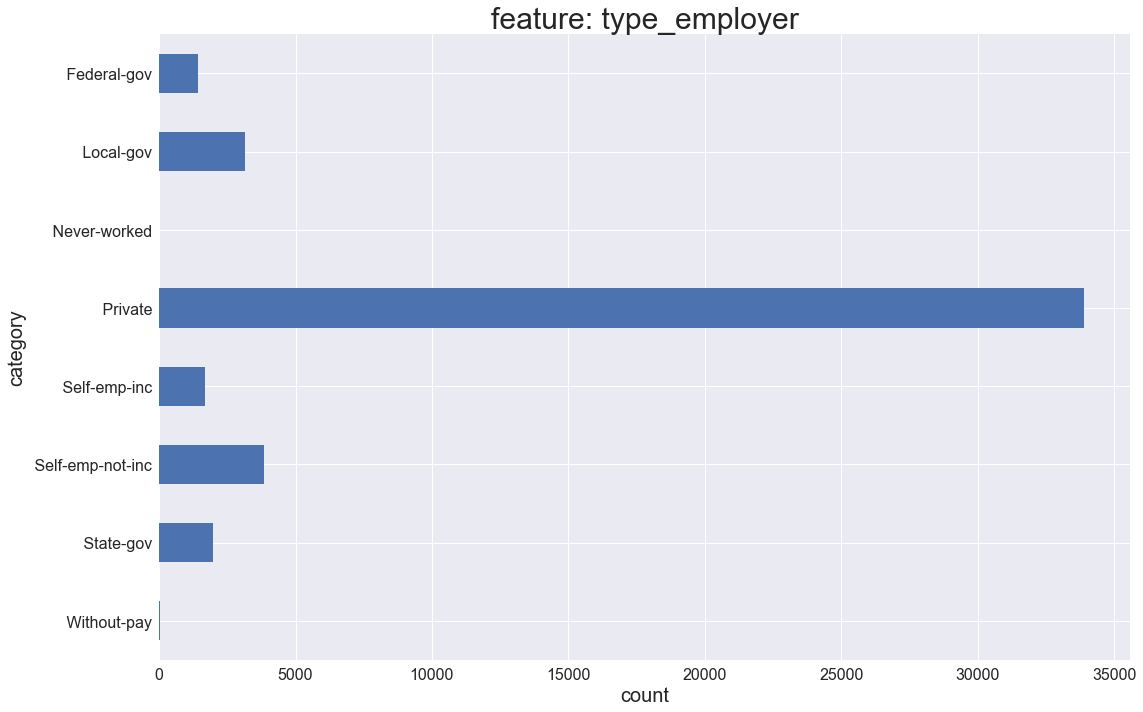

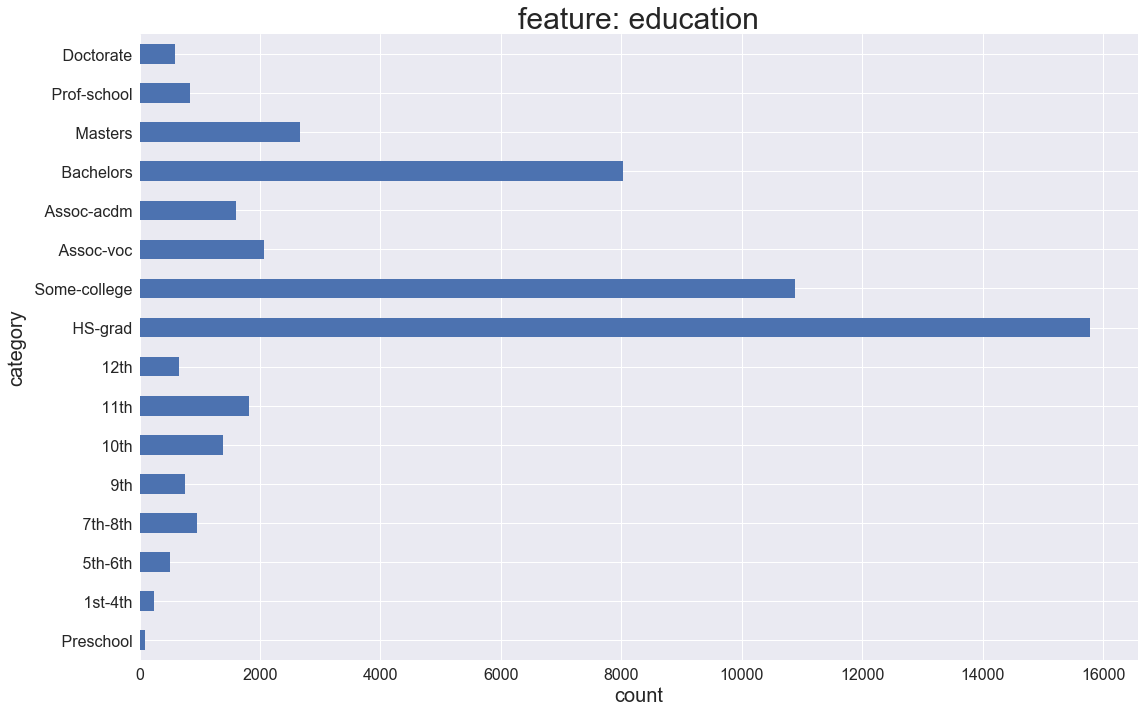

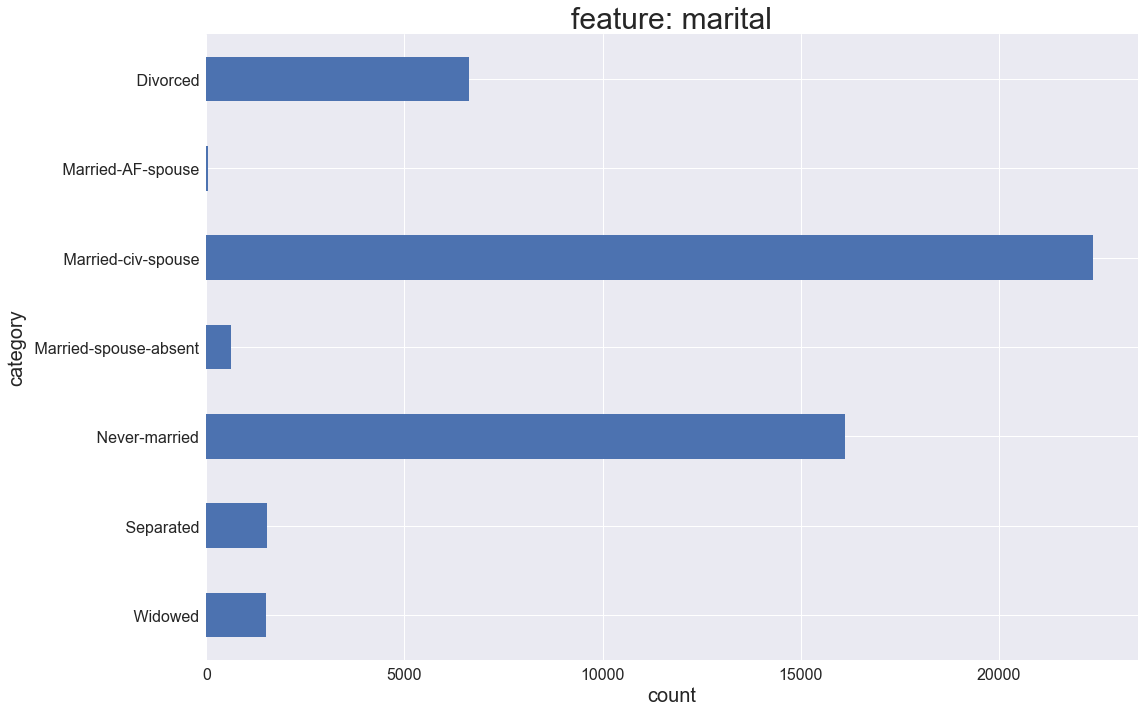

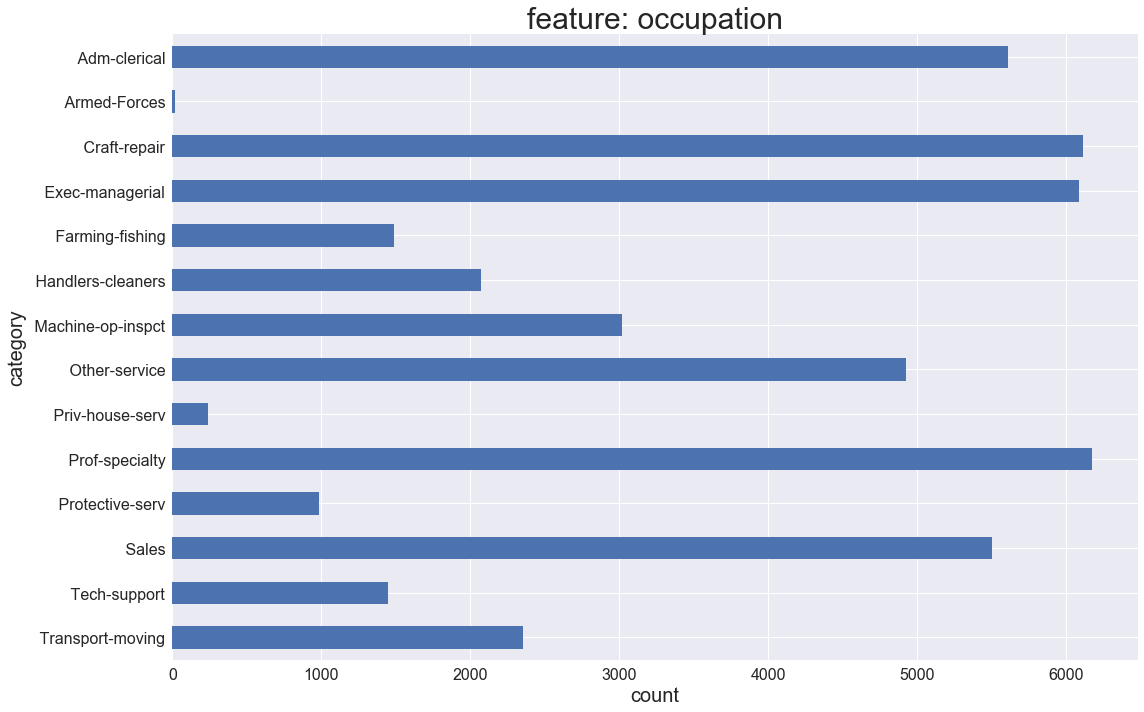

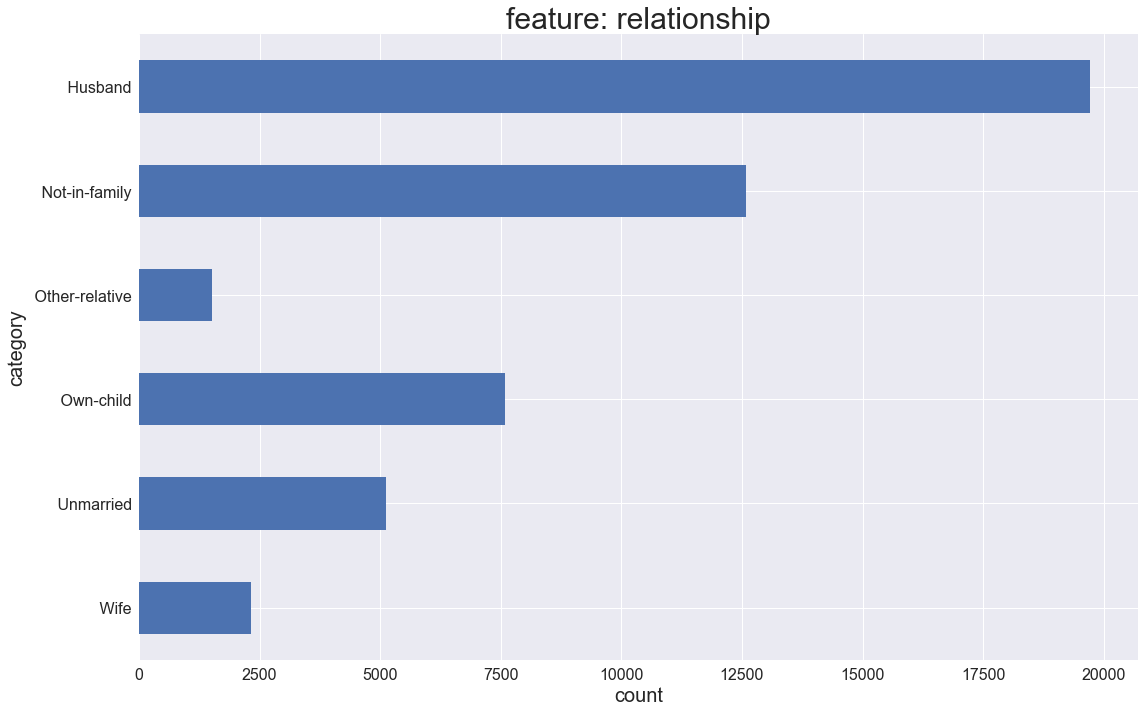

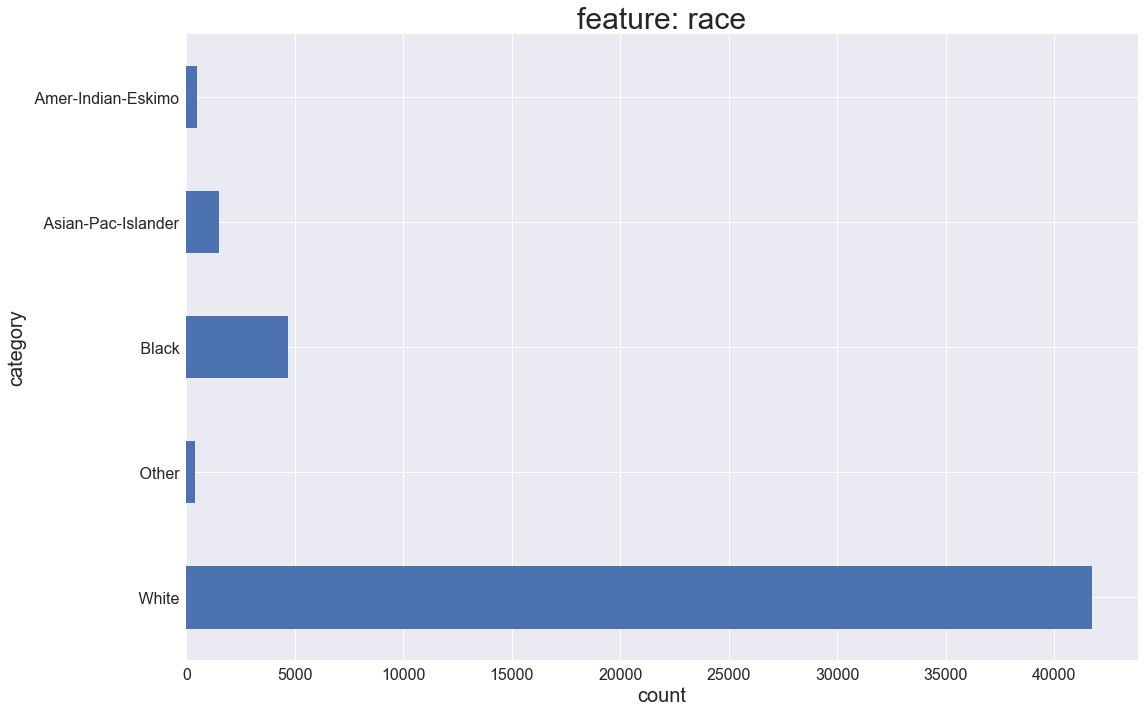

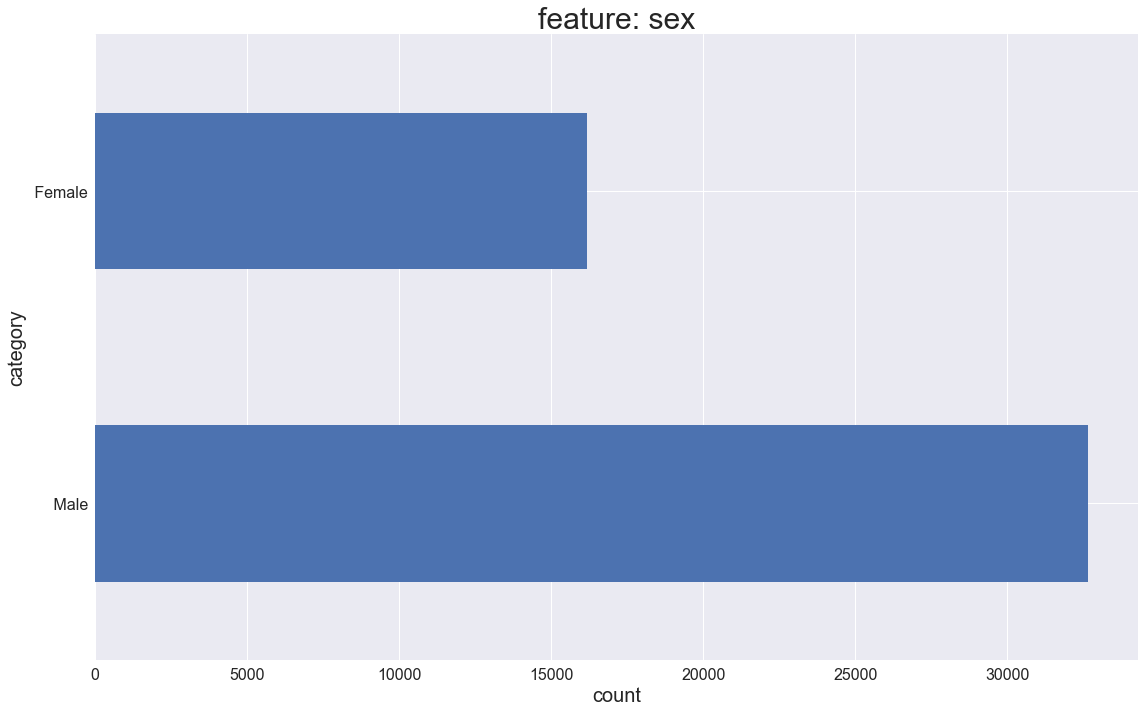

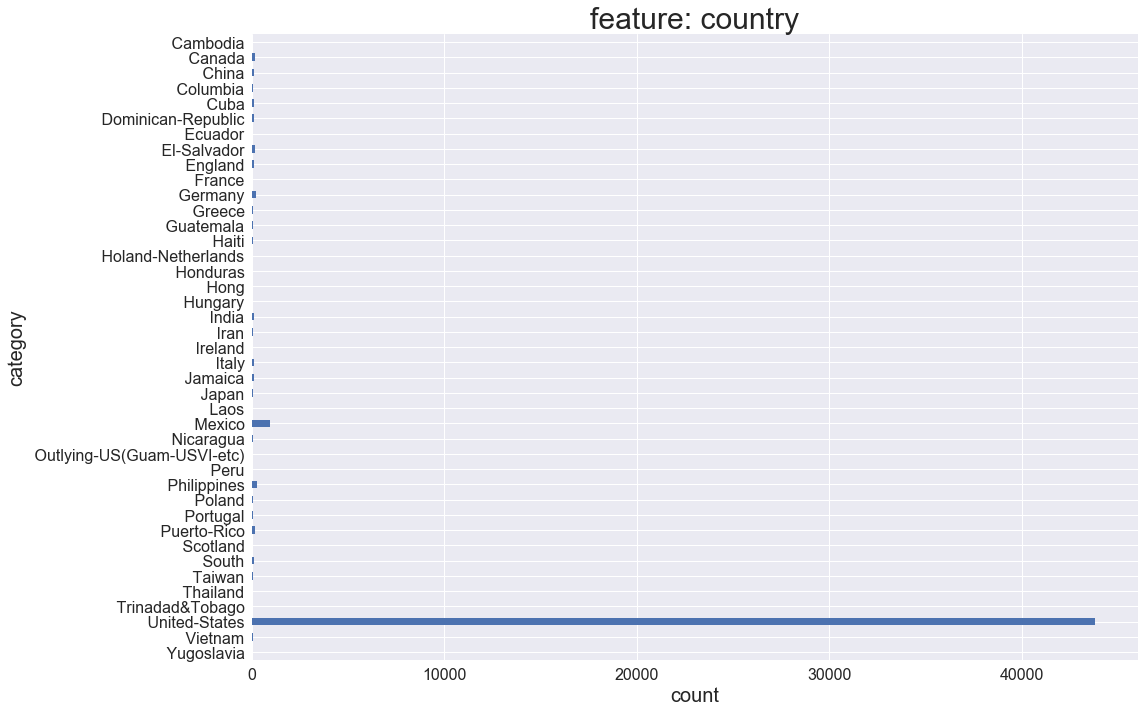

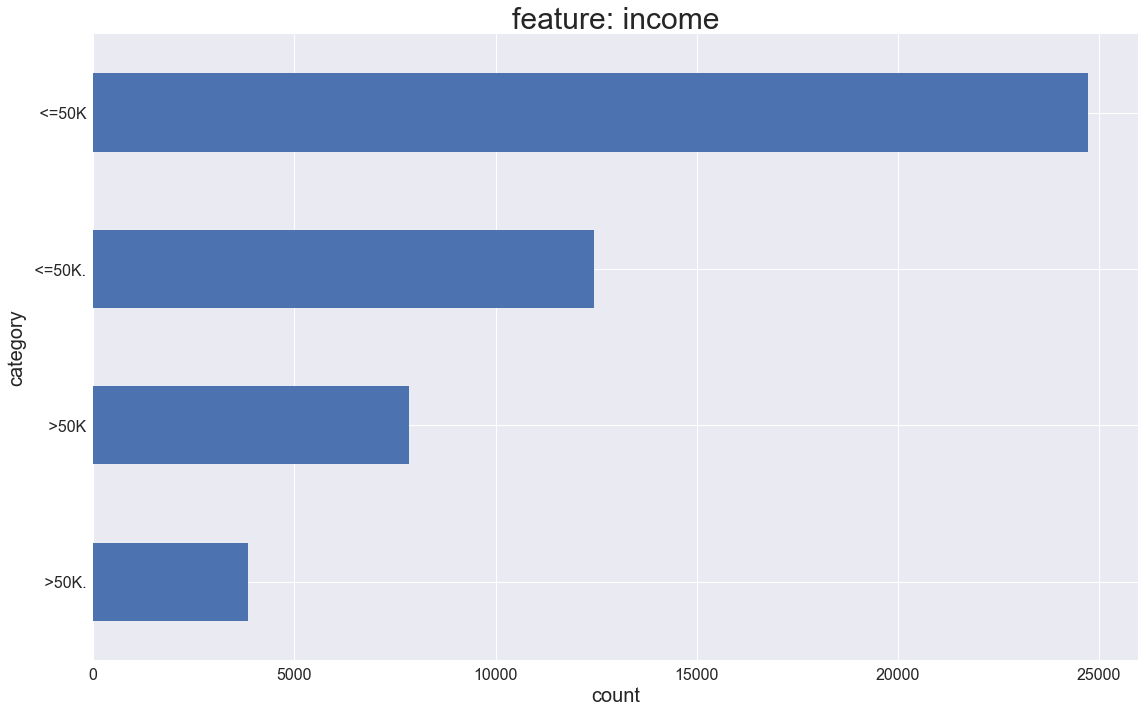

In [8]:
# define the categorical features as a list to loop through visualizing
cat_features = ['type_employer', 'education', 'marital', 'occupation', 'relationship', 'race', 'sex', 'country', 'income']

# loop through the features and visualize bar graphs
for i in cat_features:
    
    # special case for education to order it according to the feature education_num
    if i == 'education':
        temp = pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)
        ax = temp.iloc[:, 1:3].plot.barh(x=temp.iloc[:, 1], figsize=(16,10), legend=False)
    
    # all other features aside from education
    else:
        temp = get_counts(i).sort_values(i, ascending=False)
        ax = temp.plot.barh(x=temp.iloc[:, 0], figsize=(16,10), legend=False)
        
    # plot parameters (make it look readable and nice)
    plt.title(str('feature: ' + i), fontsize=30)
    plt.xlabel('count', fontsize=20)
    plt.xticks(fontsize=16)
    plt.ylabel('category', fontsize=20)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(str('../analysis/eda_' + i + '.png'))

__As tables:__

In [9]:
get_counts('type_employer')

,type_employer,count
0,Federal-gov,1432
1,Local-gov,3136
2,Never-worked,10
3,Private,33906
4,Self-emp-inc,1695
5,Self-emp-not-inc,3862
6,State-gov,1981
7,Without-pay,21


In [10]:
pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)

,education_num,education,count
0,1,Preschool,83
1,2,1st-4th,247
2,3,5th-6th,509
3,4,7th-8th,955
4,5,9th,756
5,6,10th,1389
6,7,11th,1812
7,8,12th,657
8,9,HS-grad,15784
9,10,Some-college,10878


In [11]:
get_counts('marital')

,marital,count
0,Divorced,6633
1,Married-AF-spouse,37
2,Married-civ-spouse,22379
3,Married-spouse-absent,628
4,Never-married,16117
5,Separated,1530
6,Widowed,1518


In [12]:
get_counts('occupation')

,occupation,count
0,Adm-clerical,5611
1,Armed-Forces,15
2,Craft-repair,6112
3,Exec-managerial,6086
4,Farming-fishing,1490
5,Handlers-cleaners,2072
6,Machine-op-inspct,3022
7,Other-service,4923
8,Priv-house-serv,242
9,Prof-specialty,6172


In [13]:
get_counts('relationship')

,relationship,count
0,Husband,19716
1,Not-in-family,12583
2,Other-relative,1506
3,Own-child,7581
4,Unmarried,5125
5,Wife,2331


In [14]:
get_counts('race')

,race,count
0,Amer-Indian-Eskimo,470
1,Asian-Pac-Islander,1519
2,Black,4685
3,Other,406
4,White,41762


In [15]:
get_counts('sex')

,sex,count
0,Female,16192
1,Male,32650


In [16]:
get_counts('country')

,country,count
0,Cambodia,28
1,Canada,182
2,China,122
3,Columbia,85
4,Cuba,138
5,Dominican-Republic,103
6,Ecuador,45
7,El-Salvador,155
8,England,127
9,France,38


In [17]:
get_counts('income')

,income,count
0,<=50K,24720
1,<=50K.,12435
2,>50K,7841
3,>50K.,3846


The following code saves all of the above tables in a markdown format to easily render in GitHub. For the purposes of reproducibility it has been commented out.

In [18]:
# for i in cat_features:
#     if i == 'education':
#         temp = pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)
#         temp = temp.drop('education_num', axis=1)
#     else:
#         temp = get_counts(i)
#     convert_table_markdown(temp, str('eda_' + i))

Overall, the integrity of the data itself is pretty good. It is quite clean and easy to work with. There are a few issues that we need to address before moving forward. We will go over each categorical feature to identify any issues or concerns regarding its integrity.

The first feature is `type_employer`. There is not much to say regarding this feature other than the majority of those classified appear to be in the private sector.

`Education` is a unique feature in that it can be thought of as an ordered-list of categories due to its hierarchical nature. Here we came across two categories that we did not fully understand, `Assoc-acdm` and `Assoc-voc`. After some investigation we found that acdm was an abbreviation for "academic" and that voc was an abbreviation for "vocational." The difference between these two is that an academic education consists of a variety of different subjects, where a vocational education tends to be streamlined towards a specific subject. For the purposes of this analysis it is only important to understand what the categories are.

The feature `marital` appears to be divide primarily between `divorced`, `Married-civ-spouse`, and `Never-married`. All of this seems valid based on our intuition.

Similarly, the `occupation` feature does not show anything too interesting or odd from what our base knowledge. One item to note is that there are abundantly more jobs than there are listed here, and attempting to categorize them so broadly could potentially be detrimental to the data lowering the probability at accurate estimations.

Looking at the `relationship` feature, we see something quite interesting. The category `husband` dominates the remaining categories `wife` being the second lowest. This implies that the data is imbalanced. Below we will see this when analyzing the `sex` feature. Also, a limitation regarding these categories is that they do not address whether this considers same sex marriages--how are same sex couples classified? According to Wikipedia we see that, "Prior to 1996, the Federal Government did not define marriage; any marriage recognized by a state was recognized by the Federal Government, even if that marriage was not recognized by one or more states..." We are unable to determine the precise definitions of this feature which most likely causes some level of bias within the data.

The next feature, `race`, also has significant potential for causing bias in our results. The data only presents four identifiable races and one `Other` category. Also, the data shows that the individuals represented are predominantly white. The extent to which white individuals are represented is so great that the other races, including the many that are not represented (or are classified as `Other`) may not be a representative sample. When dealing with small sample sizes there is a large propensity for bias. It is also important to note that `race` is self-reported on the US census. This leads to an excessively larger portion of people reporting `Amer-Indian-Eskimo`. Although this is not seen in the data due to the imbalance with `white` individuals.

Moving onto `sex` we again see a potential for bias. This data represents sex and not gender. The two are different and not to be confused with one another. Sex is binary (except in some extreme cases) and determined by our sexual organs at birth, whereas gender is how we choose or choose not to identify. The data is primarily comprised of males. There are more than twice as many males represented in the data as there are females.

Looking at the `country` feature we see potentially the largest imbalance in the data. This is to be expected as this data represents the US census. The definition of the feature is not explicit. It is defined as "country of origin." This does not specify if this is the country an individual was born in, or if this was the last country an individual was a resident of prior to coming to the US. We also note that countries labeled `Hong` and `South` exist. While we may interpret `Hong` to represent Hong Kong, it is under the sovereign state of China. As for `South`, we are unable to determine what country this is supposed to represent.

The last variable is `income` which represents the response variable rather than the features. Here we see some data integrity issues. The variable should be a binary classification, however, there are four different representations (two for each binary case). This data will need to cleaned to remove the duplicate codes for the same meaning. Even looking at this uncleaned data we see that individuals making more than \$50,000 are severely underrepresented when compared with those making less than or equal to \$50,000. This could be a cause for bias in the data.

### Data cleaning

Based on the EDA above, we investigate more in depth the features in the dataset; checking for duplicates, missing values (which "should" all be assigned already during the data import), and data that does not appear correct. For the purposes of this analysis we will not use the `fnlwgt` feature.

In [19]:
# drop 'fnlwgt'
df = df.drop('fnlwgt', axis=1)

Let's first look at how many rows contain missing data, and more specifcally which columns (if any) are represented in the missing data by a count of the number of occurrences.

In [20]:
# print missing data information
print('Rows with missing data: ' + str(df[df.isnull().any(axis=1)].shape[0]))
print('Rows without missing data: ' + str(df[df.notnull().all(axis=1)].shape[0]))
pd.DataFrame(df.isnull().sum(axis=0), columns=['missing_count'])

Rows with missing data: 3620
Rows without missing data: 45222


,missing_count
age,0
type_employer,2799
education,0
education_num,0
marital,0
occupation,2809
relationship,0
race,0
sex,0
capital_gain,0


We do have missing data, however, it appears to be contained to only three features, and does not occur too often relative to the size of the data. We will discuss different methods for how to handle this missing data later.

For the purposes of using the function `LabelEncoder()` we will fill all of the missing values with a string (str) as the `LabelEncoder()` function is unable to read actual `NaN` values.

In [21]:
# fill na values with string
df = df.fillna('NaN')

Based on the EDA performed above, we have identified that the `education` feature and `education_num` feature are identical and represent the same information. Due to the direct relationship (1:1), we do not need to include both of these features.

In [22]:
# drop duplicate dolumn
df = df.drop('education', axis=1)

Also identified during the EDA was `income` variable's lack of binary classification. Here we fix those classified with an extra "." creating a binary classification. The results are printed to ensure that there are only two possible categories.

In [23]:
# fix dupicate results for 'income' variable
df['income'] = df['income'].str.replace('.', '')
df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

### Deal with missing values and encode categorical features

We have chosen four different approaches for dealing with missing values and encoding categorical features. These methods represent the progression of thought, beginning with method 1 and iterating until we achieved a more optimal and sound technique with method 4.

1. Delete all rows associated with missing values reducing the total number of rows from 48,842 to 45,222 and naively encode categorical features.
2. Delete features associated with missing values reducing the feature space from 14 to 11 and naively encode categorical features.
3. Encode missing values as a category (not advised). This does not remove any features or rows.
4. Binarize the categorical features (expand feature space significantly).

__Note: The code to save the cleaned data has been commented out for the purposes of reproducibility.__

In [24]:
## method 1
# drop rows with missing data
df_m1 = df[((df['type_employer'] != 'NaN') &
            (df['occupation'] != 'NaN') &
            (df['country'] != 'NaN'))].reset_index(drop=True)
df_m1 = encode_cat_vars(df_m1)
# df_m1.to_csv('../data_clean/method1.csv', index=False)

## method 2
# drop features with missing data
df_m2 = df.drop(['type_employer', 'occupation', 'country'], axis=1).reset_index(drop=True)
df_m2 = encode_cat_vars(df_m2)
# df_m2.to_csv('../data_clean/method2.csv', index=False)

## method 3
# copy DataFrame to new variable and encode categorical variables
df_m3 = df.copy()
df_m3 = encode_cat_vars(df_m3)
# df_m3.to_csv('../data_clean/method3.csv', index=False)

## method 4
# copy DataFrame to new variable
df_m4 = df.copy()
df_m4 = binarize_cat_vars(df_m4)
df_m4 = df_m4.drop(['type_employer_NaN', 'occupation_NaN', 'country_NaN'], axis=1)
# df_m4.to_csv('../data_clean/method4.csv', index=False)

### Split DataFrame into training and testing

This split is done so that we do not perform any training on the true test set. We will split the training set later into a training/validation set that will be used to train and test the model(s). Once a model has been tuned it will be tested against the holdout test set we create below. Please note that a random state has been instantiated so that the results are reproducible.

In [25]:
# randomly split 25% for a test set
df_m1_test = df_m1.sample(frac=1/4, random_state=6)
df_m2_test = df_m2.sample(frac=1/4, random_state=6)
df_m3_test = df_m3.sample(frac=1/4, random_state=6)
df_m4_test = df_m4.sample(frac=1/4, random_state=6)

# keep the remaining 75% for a training set
df_m1_train = df_m1.drop(df_m1_test.index.values)
df_m2_train = df_m2.drop(df_m2_test.index.values)
df_m3_train = df_m3.drop(df_m3_test.index.values)
df_m4_train = df_m4.drop(df_m4_test.index.values)

### Split into features/response, training/validation, and standardize/scale data

Here we perform the standard train/validation split after first splitting the data between the features and response. The split is done as a 67/33 split such that the overall splits (including the step before) create a 50% train, 25% validation and 25% test set. Please note that, as above, a random state has been instantiated so that the results are reproducible.

In [26]:
# prepare the data for modeling
x_train_m1, x_valid_m1, y_train_m1, y_valid_m1 = data_prep(df_m1_train)
x_train_m2, x_valid_m2, y_train_m2, y_valid_m2 = data_prep(df_m2_train)
x_train_m3, x_valid_m3, y_train_m3, y_valid_m3 = data_prep(df_m3_train)
x_train_m4, x_valid_m4, y_train_m4, y_valid_m4 = data_prep(df_m4_train)

# standardize and scale the test set as well (no split)
x_test_m1, x_null_m1, y_test_m1, y_null_m1 = data_prep(df_m1_test)
x_test_m2, x_null_m2, y_test_m2, y_null_m2 = data_prep(df_m2_test)
x_test_m3, x_null_m3, y_test_m3, y_null_m3 = data_prep(df_m3_test)
x_test_m4, x_null_m4, y_test_m4, y_null_m4 = data_prep(df_m4_test)

# combine the splits back (just utilized the function to standardize and scale)
x_test_m1 = np.vstack((x_test_m1, x_null_m1))
y_test_m1 = np.append(y_test_m1, y_null_m1)
x_test_m2 = np.vstack((x_test_m2, x_null_m2))
y_test_m2 = np.append(y_test_m2, y_null_m2)
x_test_m3 = np.vstack((x_test_m3, x_null_m3))
y_test_m3 = np.append(y_test_m3, y_null_m3)
x_test_m4 = np.vstack((x_test_m4, x_null_m4))
y_test_m4 = np.append(y_test_m4, y_null_m4)

## Findings
[[back to Contents](#Contents)]

We will look at three different measurements for our findings. First we will look at the logistic regression models for each of the four methods mentioned above. Next, we will look at the coefficients obtained from the models and see if any of them are more deterministic than others. Lastly, we will look at the Pearson correlations for the four methods, correlating all features and the response variable.

### Fit logistic regression model with cross-validation and calculate accuracy

This serves to address [RQ1](#Research-Questions): Given a set of features, can we predict whether the income of a person will be greater than or less than $50,000?

In [28]:
print('Method 1:')
model1 = model_logistic(x_train_m1, x_valid_m1, x_test_m1, y_train_m1, y_valid_m1, y_test_m1)
print('\nMethod 2:')
model2 = model_logistic(x_train_m2, x_valid_m2, x_test_m2, y_train_m2, y_valid_m2, y_test_m2)
print('\nMethod 3:')
model3 = model_logistic(x_train_m3, x_valid_m3, x_test_m3, y_train_m3, y_valid_m3, y_test_m3)
print('\nMethod 4:')
model4 = model_logistic(x_train_m4, x_valid_m4, x_test_m4, y_train_m4, y_valid_m4, y_test_m4)

Method 1:
Validation Accuracy: 81.75%
Test Accuracy: 82.05%
Confusion Matrix:
[[7979  545]
 [1484 1298]]

Method 2:
Validation Accuracy: 82.60%
Test Accuracy: 82.59%
Confusion Matrix:
[[8773  522]
 [1604 1311]]

Method 3:
Validation Accuracy: 83.14%
Test Accuracy: 82.72%
Confusion Matrix:
[[8792  503]
 [1607 1308]]

Method 4:
Validation Accuracy: 85.42%
Test Accuracy: 85.59%
Confusion Matrix:
[[8631  664]
 [1095 1820]]


Based on the above accuracy scores, we do see that we can predict the income classification of an individual with adequate accuracy. If this was purely guessing we would achieve approximately 50% accuracy, and if we only guessed `<=50K` we would achieve approximately 76% accuracy.

From the confusion matrices we see that for models 1, 2, and 3 we more often predict the `>50K` incorrectly, however, with model 4 we are more accurate at predicting `>50K` (now above 50% accuracy), with a slight reduction in the accuracy at predicting `<=50K`. The confusion matrices provide a good analysis on their own of the accuracy of the models created and what could be done to further improve accuracy.

### Visualize the coefficients

Using the models created above, we will now look at the associated coefficients and their relative strength in each prediction model. This serves to answer [RQ2](#Research-Questions): Which feature is the most important in determining income classification?

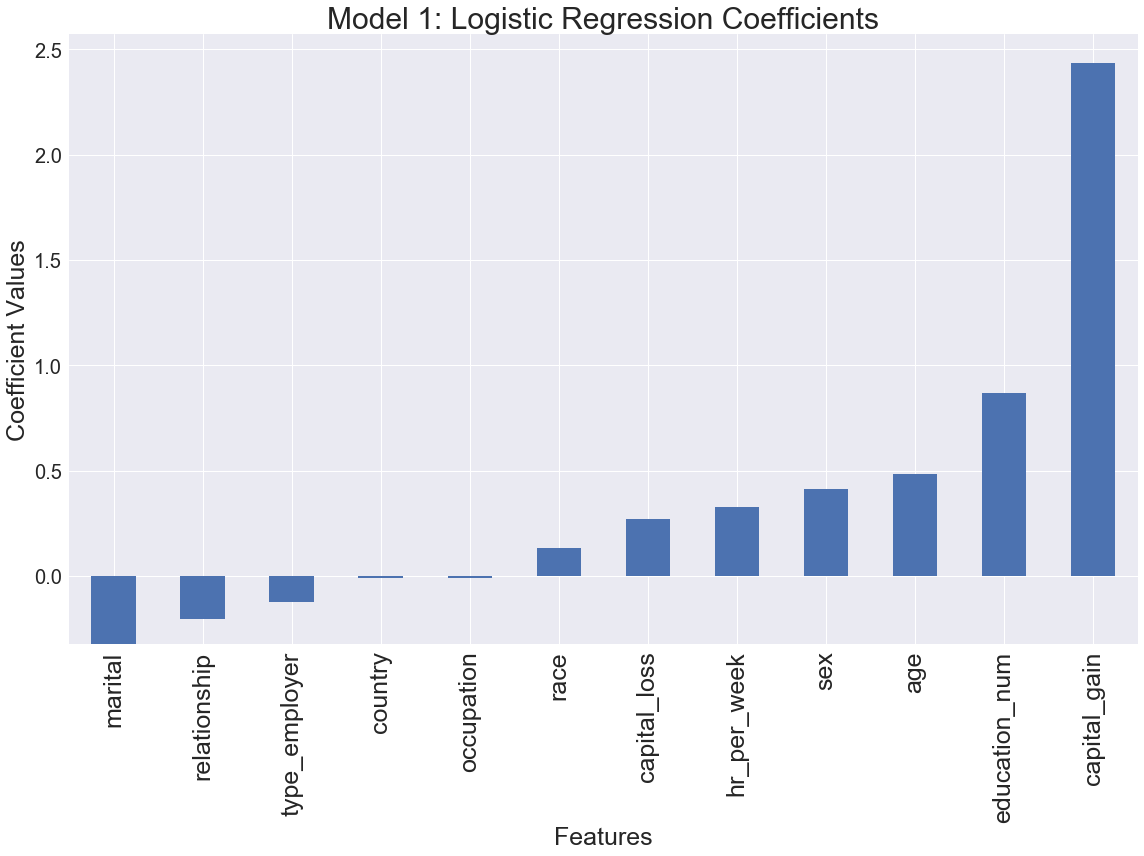

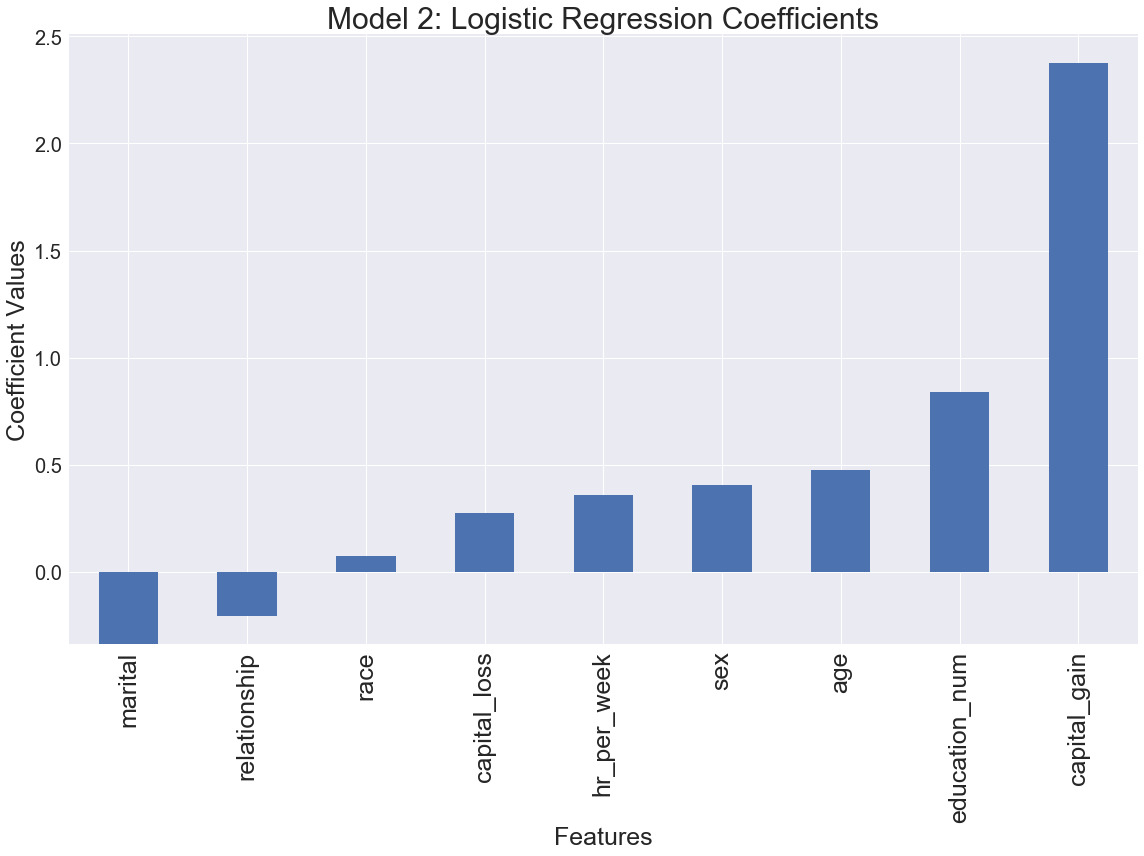

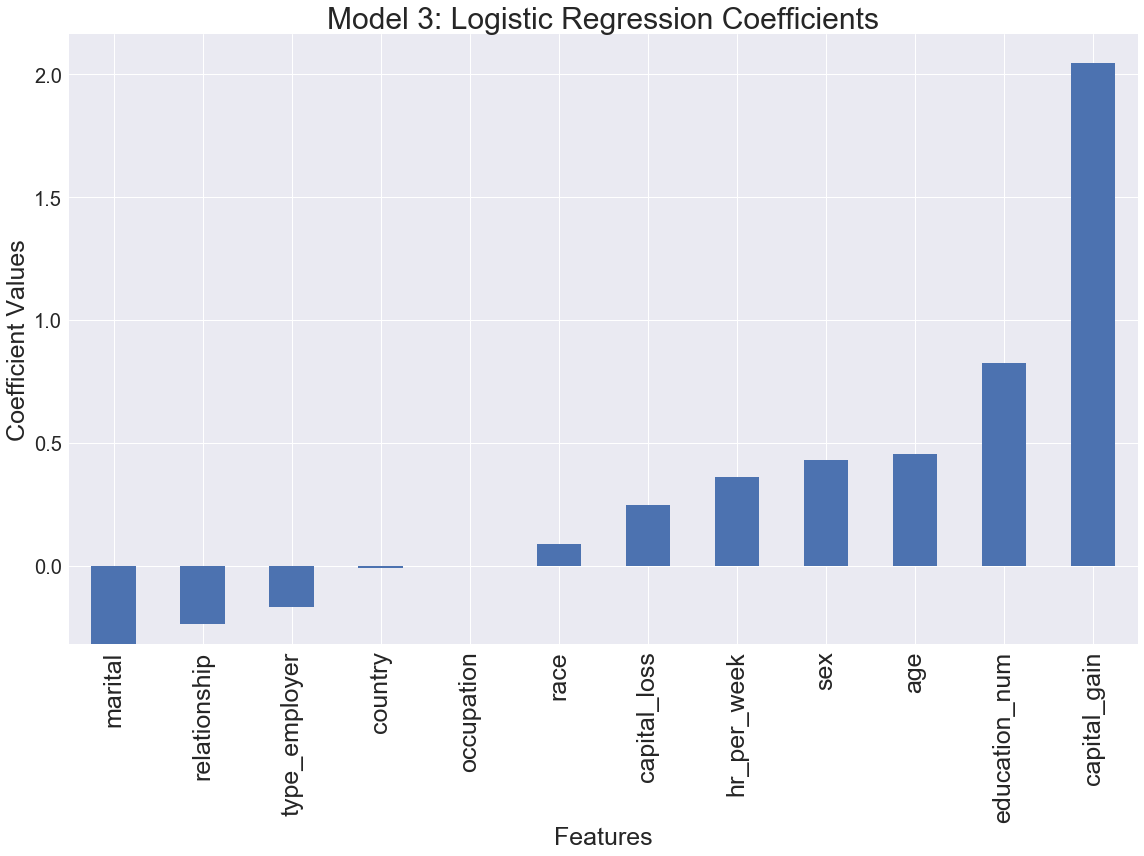

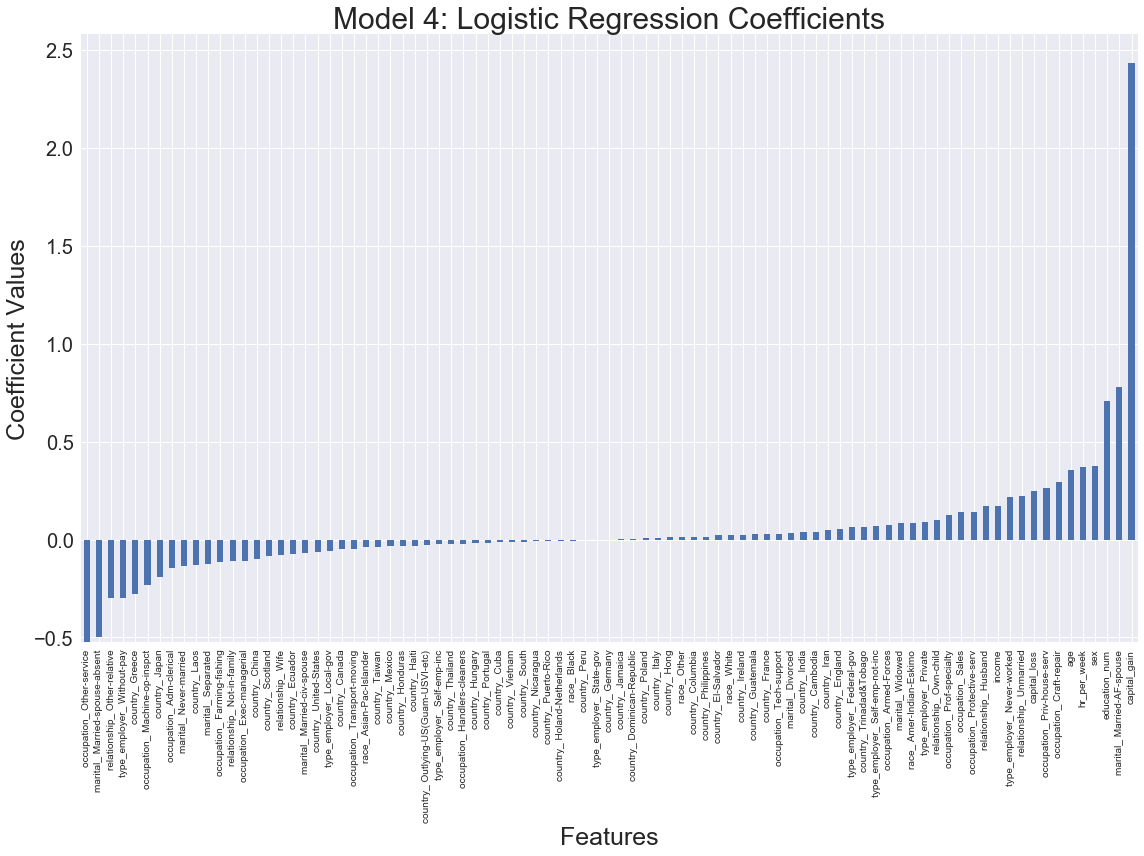

In [31]:
visualize_coefs(model1, df_m1, title_prefix='Model 1: ')
# plt.savefig('../analysis/m1_coefficient_values_bargraph.png')
visualize_coefs(model2, df_m2, title_prefix='Model 2: ')
# plt.savefig('../analysis/m2_coefficient_values_bargraph.png')
visualize_coefs(model3, df_m3, title_prefix='Model 3: ')
# plt.savefig('../analysis/m3_coefficient_values_bargraph.png')
visualize_coefs(model4, df_m4, title_prefix='Model 4: ', tick_size=10)
# plt.savefig('../analysis/m4_coefficient_values_bargraph.png')

The first three methods offer less detail, but provide consistent results. The top four predictors all seem to be consistent with `capital_gain`, `education_num`, `age`, and `sex`. Capital gain has much more predictive value, however, this is a biased indicator as we saw during the [EDA](#Exploratory-data-analysis---EDA) that the `capital_gain` feature only accounted for 2,282 individuals out of the total 48,842. The predictive power of this feature is not as important because the relative number of occurrences is low. The other three features that have high predictive power appear to be consistent with assumptions.

One thing to note is that the categorical features all seem to be lacking predictive power in the models 1, 2, and 3. This is due to the confounding introduced when attempting to numerically classify them when they are not representative of any ordered list. In model 4 we see some of these categorical features become more powerful in the prediction model such as `marital` and `occupation`. In the previous three models we saw `marital` as the least predictive of the features. By binarizing the categorical features we remove some of the bias of arbitrarily assigning them numerical values and achieve more predictive power.

### Visualize Pearson correlation confusion matrix among features

Lastly, we will look at the correlations between all of the features and the response variable. This serves to answer [RQ3](#Research-Questions): Ignoring income, what factors appear to be highly correlated with each other?

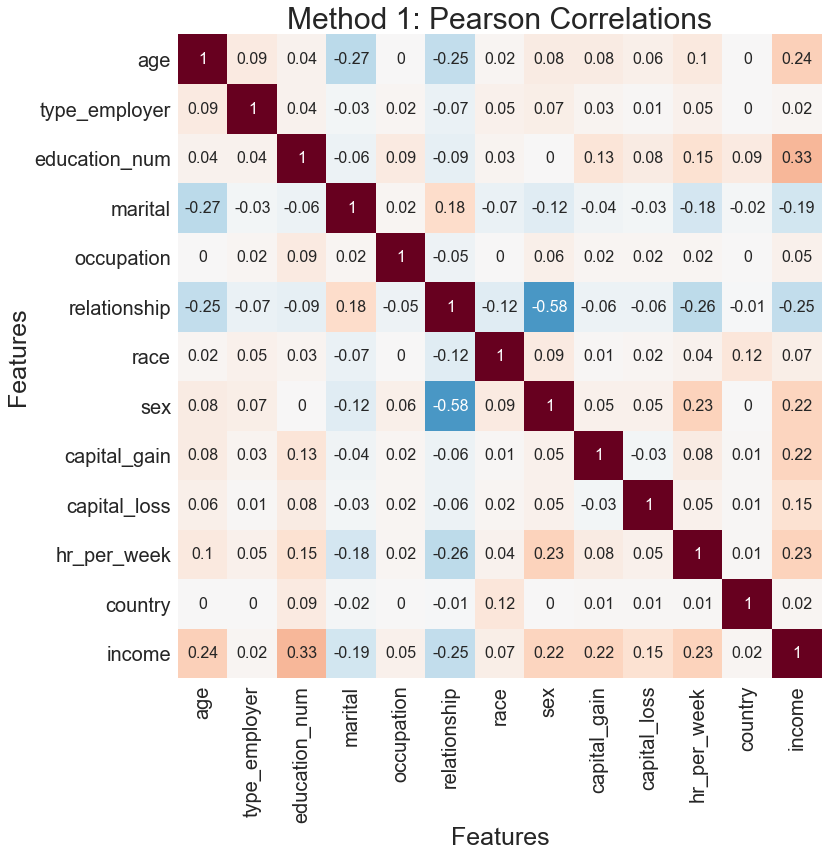

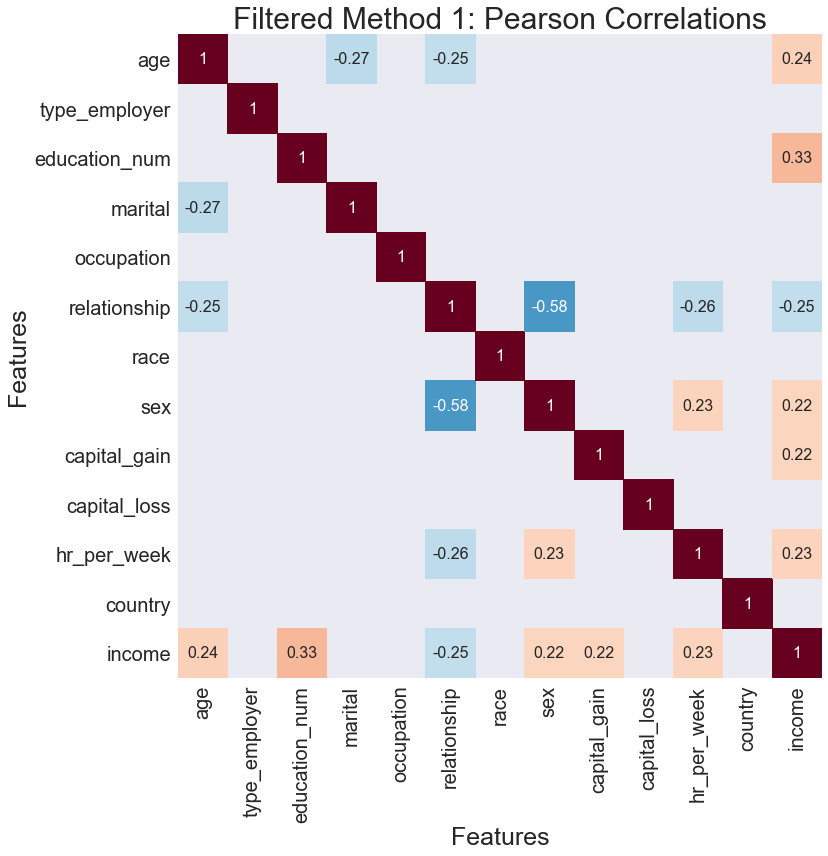

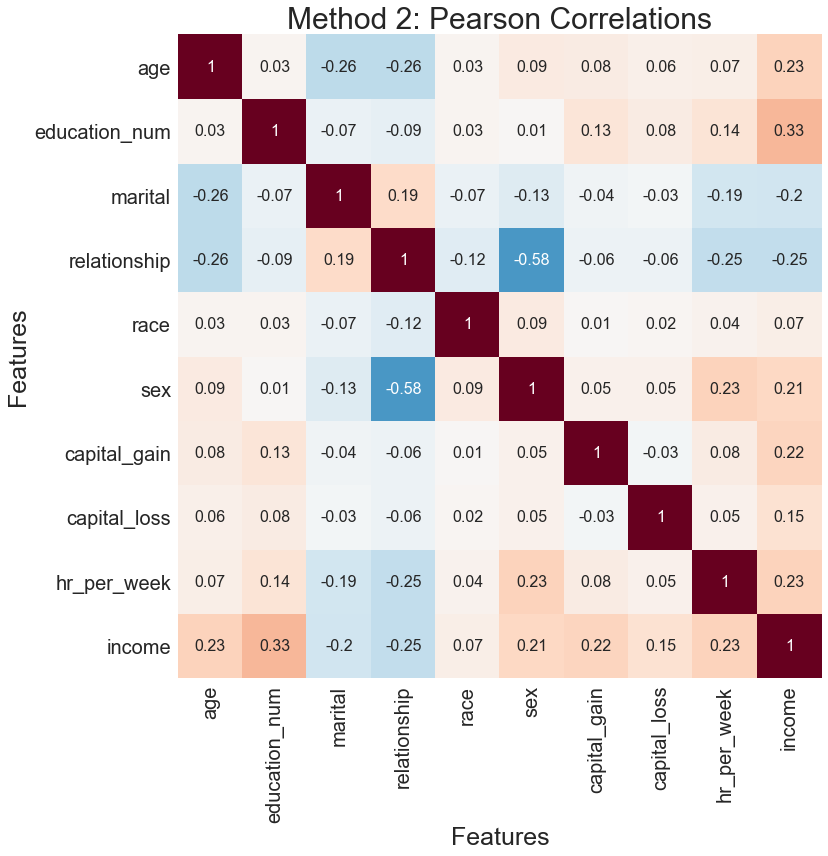

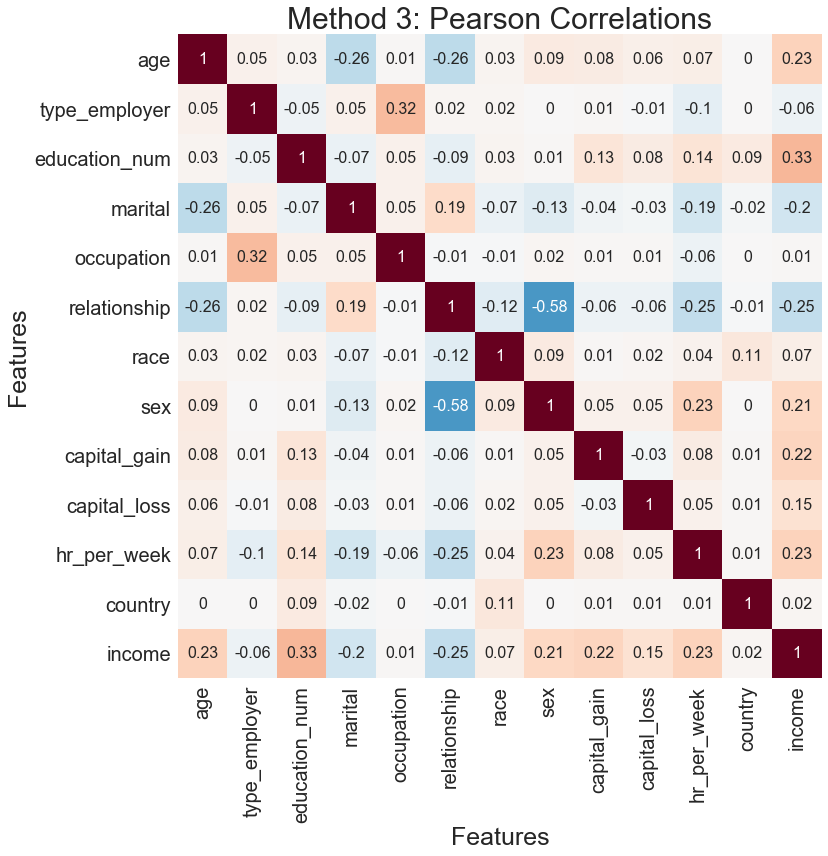

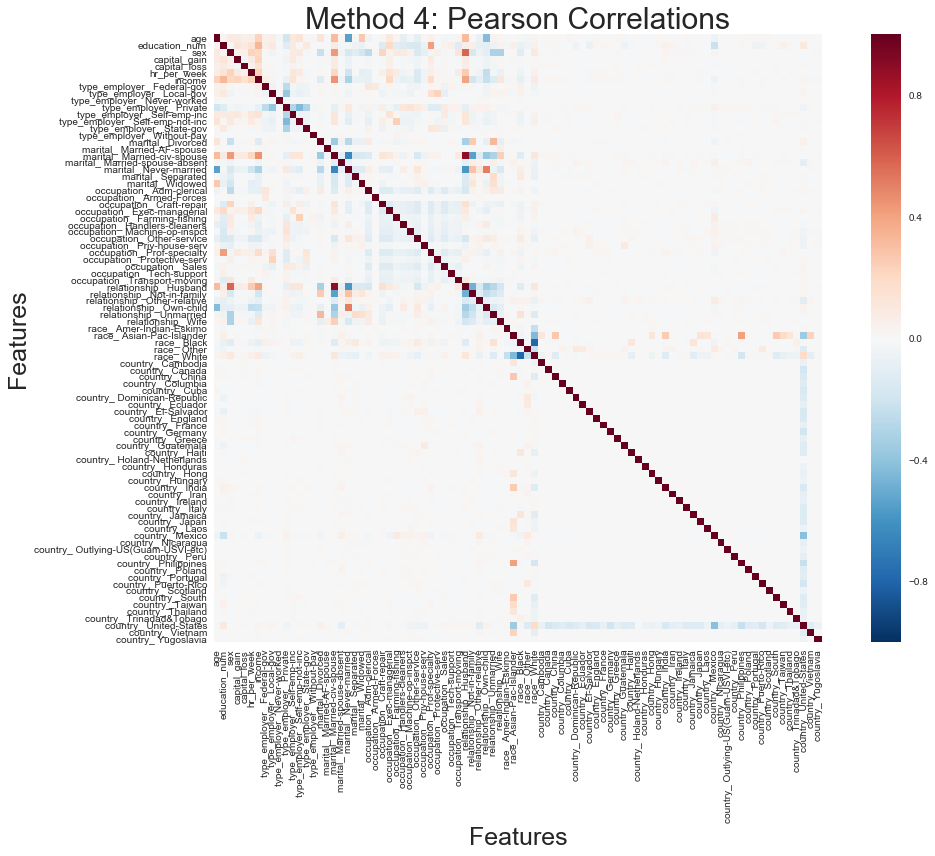

In [30]:
corr_heatmap(df_m1, title_prefix='Method 1: ')
# plt.savefig('../analysis/m1_pearson_corr_heatmap.png')
corr_heatmap(df_m1, title_prefix='Filtered Method 1: ', threshold=0.2)
# plt.savefig('../analysis/m1_pearson_corr_heatmap_filtered.png')
corr_heatmap(df_m2, title_prefix='Method 2: ')
# plt.savefig('../analysis/m2_pearson_corr_heatmap.png')
corr_heatmap(df_m3, title_prefix='Method 3: ')
# plt.savefig('../analysis/m3_pearson_corr_heatmap.png')
corr_heatmap(df_m4, title_prefix='Method 4: ', figsize=(16, 12), annot=False, cbar=True, tick_size=10)
# plt.savefig('../analysis/m4_pearson_corr_heatmap.png')

The correlation heatmaps can be difficult to look at, however, for method 1 we have applied a threshold in order to highlight the more serious correlations. We see the correlations we would expect such as `marital` and `age`. Individuals in the US tend to get married within a certain age range. While this is not true for all, it is true for the majority. We see another expected correlation between `sex` and `relationship`. One more surprising correlation that comes about when looking at the heatmap is the relationship between `hr_per_week` and `sex`. This is not necessarily a relationship we would expect to see. This would be an area for further investigation to determine what factors (if any) are contributing to this correlation.

## Discussion/Implications
[[back to Contents](#Contents)]

### Limitations

The most obvious limitation in this analysis is the dataset that we are working with. This study was performed in 2017 using a dataset from 1994. While not irrelevant, it is not a recent dataset. Combining this study with progressively more recent (and potentially historical) datasets could provide unique insight into the trends over time.

Another limitation is the detail of the data. With only 15 columns, there is not a significant sized feature space to accurately "classify" all individuals within the US. Even with the current feature space provided, the detail is severely lacking.

As noted earlier, other features have some limitations as follows:

 - `occupation` - There are abundantly more jobs than there are listed here, and attempting to categorize them so broadly could potentially be detrimental to the data lowering the probability at accurate estimations.

 - `relationship` - The category `husband` dominates the remaining categories with `wife` being the second lowest. This implies that the data is imbalance. Another limitation regarding these categories is that they do not address whether this considers same sex marriages--how are same sex couples classified? According to Wikipedia we see that, "Prior to 1996, the Federal Government did not define marriage; any marriage recognized by a state was recognized by the Federal Government, even if that marriage was not recognized by one or more states..." We are unable to determine the precise definitions of this feature which most likely causes some level of bias within the data.

 - `race` - The data only presents four identifiable races and one `Other` category. Also, the data shows that the individuals represented are predominantly `white`. The extent to which `white` individuals are represented is so great that the other races, including the many that are not represented (or are classified as `Other`) may not be a representative sample. When dealing with small sample sizes there is a large propensity for bias. It is also important to note that race is self-reported on the US census. This leads to an excessively larger portion of people reporting `Amer-Indian-Eskimo`. Although this is not seen in the data due to the imbalance with white individuals.

 - `sex` -  This data represents sex and not gender. The two are different and not to be confused with one another. Sex is binary (except in some extreme cases) and determined by our sexual organs at birth, whereas gender is how we choose or choose not to identify. The data is primarily comprised of males. There are more than twice as many males represented in the data as there are females.

 - `country` - We see potentially the largest imbalance in the data with this feature. This is to be expected as this data represents the US census. The definition of the feature is not explicit. It is defined as "country of origin." This does not specify if this is the country an individual was born in, or if this was the last country an individual was a resident of prior to coming to the US. We also note that countries labeled Hong and South exist. While we may interpret Hong to represent Hong Kong, it is under the sovereign state of China. As for South, we are unable to determine what country this is supposed to represent.

 - `income` - Here we see some data integrity issues. Looking at this data we see that individuals making more than \$50,000 are severely underrepresented when compared with those making less than or equal to $50,000. This could be a cause for bias in the data. Also, classifying individuals into two income categories is very limiting. It would be much more beneficial to have a continuous response variable for `income`. There are significantly more analyses that could be performed if this were the case.

### Future Research

The results from this analysis are not as interesting as hoped when we first sought out to look the US Adut Census data. In order to see some of the more nuanced correlations, we believe a more detailed dataset is required. One that is not as imbalanced as the US Adult Census one used in this analysis. Such a large imbalance causes a large bias in the results which we have shown above.

Obtaining a more detailed dataset is a first step towards producing a better analysis. Additionally, multiple dataset covering a wider range of years would allow an analysis that shows the trends over time to see if income gaps have changed.

We have shown that it is possible to create a predictive model with adequate accuracy. With better data and more data this accuracy could be significantly improved. Also, it would be worthwhile exploring other classification models with a better dataset. Improving the accuracy of these models is important because with a very detailed and accurate model we can gain a better understanding of the contributing factors that go into building the model. These factors are what we need to address if there are income gaps that exist that are uncontrollable by individuals.

## Conclusion
[[back to Contents](#Contents)]

We set out to discover what factors contribute most to the income gap that are out of a person's control in order to further address these factors in future research. While obtaining some relevant results, we ultimately came to the conclusion that the data itself is not of substantial enough integrity in order to accurately find all factors contributing to income gaps.

- RQ1: Given a set of features, can we predict whether the income of a person will be greater than or less than $50,000?

  Based on the analysis we discovered that it is possible to predict, with approximately 85% accuracy, the income of an individual as a binary classification. We believe that with more detailed data, and an expansion of the feature space, it is possible to more accurately predict the income classification of an individual. We note that we only tested a logistic regression model with cross-validation, and acknowledge that there are other classification models that may better fit the dataset.

  Also, it is noted that the income response being a boolean variable is detrimental to the dataset as a whole. If this were to be a continuous variable it would allow more precision, and more importantly, insight into the degree with which an individual's income is based on a set of factors.


- RQ2: Which feature is the most important in determining income classification?

  Through the [EDA](#Exploratory-data-analysis---EDA) we realized that the features within the dataset had the potential to have extreme biases on the dataset. After modeling the data, it was readily apparent that there was a significant bias due to the nature of the features. This includes unbalanced sampling which leads to a sample that may not be representative of the population, lack of data for all individuals (in the case of capital gains), and features that are too vague as seen with the category `Other` within the feature `race`.
  
  The features that were most important in determining income classification were `capital_gain`, `marital` (specifically `Married-AF-spouse`), `education_num`, and `sex`. This is based off of the results from method 4 above. 


- RQ3: Ignoring income, what factors appear to be highly correlated with each other?

  In general the features that are highly correlated are those that we would intuitively expect. The only surprising result is that the features `sex` and `hr_per_week` were highly correlated with respect to the Pearson correlation matrices above. These results are confounded by the lack of data integrity, and may be different if a more detailed dataset were obtained.

Humans are very complex. Attempting to categorize them binarily is limiting and should have been the first hint that the dataset is lacking integrity. Performing data science analytics with respect to humans needs to be highly detailed and consider all facets of the human element. We recognize that no matter how in-depth we go and how many aspects we consider, there will always be something that slips by adding a level of confounding to our research. It is our duty as researchers to address all such limitations and state what should be done to address them. People are not simply numbers, even if we try to fit them into different categories. Taking a step back and performing an analysis with human-centered data science in mind will help to address many issues that confound research.

## References
[[back to Contents](#Contents)]

1. S. Sathiya Keerthi and Kaibo Duan and Shirish Krishnaj Shevade and Aun Neow Poo. A Fast Dual Algorithm for Kernel Logistic Regression. ICML. 2002.

2. Rakesh Agrawal and Ramakrishnan ikant and Dilys Thomas. Privacy Preserving OLAP. SIGMOD Conference. 2005.

3. Li-Ping Tang, Thomas, Theresa Li-Na Tang, and Beeta Yazmeen Homaifar. "Income, the love of money, pay comparison, and pay satisfaction: Race and gender as moderators." Journal of Managerial Psychology 21.5 (2006): 476-491.

4. Saharon Rosset. Model selection via the AUC. ICML. 2004.

5. Wikipedia contributors. "Same-sex marriage in the United States." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 9 Dec. 2017. Web. 9 Dec. 2017.

6. “Income Inequality.” Inequality.org, inequality.org/facts/income-inequality.

7. Wikipedia contributors. "Income Inequality in the United States." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 9 Dec. 2017. Web. 9 Dec. 2017.

8. Dollar, David, and Roberta Gatti. Gender inequality, income, and growth: are good times good for women?. Vol. 1. Washington, DC: Development Research Group, The World Bank, 1999.

9. Blau, Francine D., and Lawrence M. Kahn. "The US gender pay gap in the 1990s: Slowing convergence." ILR Review 60.1 (2006): 45-66.